In [1]:
# Import Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
from itertools import cycle
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display
from scipy import stats

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence, select_months
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
from kmeans import *
import nclcmaps as ncl

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [ ]:
def preprocess_ar_area_subregions(df, thres):
    '''
    Returns dataframe encoded for AR Days and identifies subregion where AR is present.
    
    Parameters
    ----------
    df : pandas dataframe
        dataframe that has subregion where percentage of area of AR is given for each day
    threshold: number, float
        singular threshold used for the percentage of area covered by an AR
        
    Returns
    -------
    df : pandas dataframe
        df that indicates whether each time step is an AR day and the location of the AR
    '''
    ## drop lev and ens cols
    df = df.drop(columns=['lev', 'ens'])
    ## resample area to keep max
    
    df = df.resample('1D').mean()
    # Add column of AR days based on threshold
    # (no LLJ day eq 0; LLJ day eq 1)
    df['ar'] = 0
    idx = (df['R01'] > thres) | (df['R02'] > thres) | (df['R03'] > thres)
    df.loc[idx, 'ar'] = 1

    # Add column of AR locations 
    # ('R01', 'R02', 'R03', 'R01/R02', 'R02/R03', 'R01/R03', 'R01/R02/R03', nan)
    df['location'] = np.nan

    idx = (df['R01'] >= thres) & (df['R02'] < thres) & (df['R03'] < thres)
    df.loc[idx, 'location'] = 'R01'

    idx = (df['R01'] < thres) & (df['R02'] >= thres) & (df['R03'] < thres)
    df.loc[idx, 'location'] = 'R02'

    idx = (df['R01'] < thres) & (df['R02'] < thres) & (df['R03'] >= thres)
    df.loc[idx, 'location'] = 'R03'

    idx = (df['R01'] >= thres) & (df['R02'] >= thres) & (df['R03'] < thres)
    df.loc[idx, 'location'] = 'R01/R02'

    idx = (df['R01'] < thres) & (df['R02'] >= thres) & (df['R03'] >= thres)
    df.loc[idx, 'location'] = 'R02/R03'

    idx = (df['R01'] >= thres) & (df['R02'] < thres) & (df['R03'] >= thres)
    df.loc[idx, 'location'] = 'R01/R03'

    idx = (df['R01'] >= thres) & (df['R02'] >= thres) & (df['R03'] >= thres)
    df.loc[idx, 'location'] = 'R01/R02/R03'
    
    return df

In [29]:
df_6hr = ds.to_dataframe()
df_6hr

djf_df = select_months(df_6hr, 12, 2)


In [34]:
nevents = djf_df['R03_id'].nunique()
print(nevents)

450


In [35]:
# stack up 3 subregions id numbers
d = {'r01id': djf_df['R01_id'],
     'r02id': djf_df['R02_id'],
     'r03id': djf_df['R03_id']}

df1 = pd.DataFrame(data=d)
df1 = df1.stack()
df1

## combine into single series

## resample to 1D taking maximum of new column

## manually add column back into resampled df with area covered

time                      
1979-01-03 12:00:00  r01id        14.0
1979-01-06 12:00:00  r01id        56.0
1979-01-06 18:00:00  r01id        56.0
1979-01-07 12:00:00  r01id        67.0
1979-01-07 18:00:00  r01id        67.0
                                ...   
2019-02-28 06:00:00  r03id    128055.0
2019-02-28 12:00:00  r01id    128066.0
                     r03id    128055.0
2019-02-28 18:00:00  r01id    128064.0
                     r03id    128055.0
Length: 6015, dtype: float64

In [37]:
nevents = df1.nunique()
print(nevents/4)

271.5


In [38]:
df1.columns

AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
df_daily = df1.resample('24H',how={'heat_index':'max'})

In [28]:
compare_12 = df_6hr['R01_id'].eq(df_6hr['R02_id'], fill_value = 0.0)

df_6hr[compare_12]

,R01,R01_id,R02,R02_id,R03,R03_id,lev,ens
time,,,,,,,,
1979-01-13 06:00:00,0.244898,121.0,0.102041,121.0,0.000000,NaN,1000.0,1.0
1979-01-13 12:00:00,0.204082,121.0,0.163265,121.0,0.000000,NaN,1000.0,1.0
1979-01-28 12:00:00,0.020408,231.0,0.346939,231.0,0.102041,231.0,1000.0,1.0
1979-01-28 18:00:00,0.081633,231.0,0.510204,231.0,0.204082,231.0,1000.0,1.0
1979-01-29 00:00:00,0.081633,231.0,0.551020,231.0,0.408163,231.0,1000.0,1.0
...,...,...,...,...,...,...,...,...
2019-08-16 12:00:00,0.469388,129582.0,0.367347,129582.0,0.000000,NaN,1000.0,1.0
2019-08-17 00:00:00,0.285714,129590.0,0.693878,129590.0,0.000000,NaN,1000.0,1.0
2019-08-17 06:00:00,0.142857,129590.0,0.387755,129590.0,0.000000,NaN,1000.0,1.0


In [27]:
np.array(np.unique(compare_12, return_counts=True))

array([[    0,     1],
       [55548,  3864]])

In [6]:
## Select MERRA2 or ERA5
reanalysis = 'era5'

if reanalysis == 'era5':
    start_date = '1979-01-01'
    end_date = '2019-12-31'
#     filename = 'ar_catalog_ERAI_fraction_HASIAsubregions.nc'
    filename = 'ar_catalog_v3_ERAI_fraction_HASIAsubregions.nc'
## if MERRA2
else:
    start_date = '1980-01-01'
    end_date = '2017-12-31'
    filename = 'ar_catalog_fraction_HASIAsubregions.nc'
    
f1 = path_to_data + 'CH1_generated_data/' + filename
ds = xr.open_dataset(f1)
# Set dates
ds = ds.sel(time=slice(start_date, end_date))
## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=ds.to_dataframe(), thres=0.3)
# Show table
df.head()

,R01,R01_id,R02,R02_id,R03,R03_id,ar,location
time,,,,,,,,
1979-01-01,0.000000,NaN,0.0,NaN,0.0,NaN,0,NaN
1979-01-02,0.000000,NaN,0.0,NaN,0.0,NaN,0,NaN
1979-01-03,0.005102,14.0,0.0,NaN,0.0,NaN,0,NaN
1979-01-04,0.000000,NaN,0.0,NaN,0.0,NaN,0,NaN
1979-01-05,0.000000,NaN,0.0,NaN,0.0,NaN,0,NaN


In [7]:
# how many ARs in HMA between start date and end date?
print('Number of ARs between 1979 and 2019: ', df.ar.sum())
# how many ARs on average per year?
print('Average number of ARs per year: ', df.ar.sum()/40.)

Number of ARs between 1979 and 2019:  1417
Average number of ARs per year:  35.425


In [8]:
def persist_and_duration_stats(x):
    '''
    Count number of independent AR events and their duration in days
    '''
    event_id, nevents, duration = persistence(x.ar)
    print('Total number of AR days in season: ', x.ar.sum())
    print('Total number of independent AR events: ', nevents)
    duration_freq = np.array(np.unique(duration, return_counts=True))
    print(duration_freq)
    bins = np.array([[1, 1], [2, 2], [3, 4], [5, 10]])
    sizes = []
    for i, b in enumerate(bins):
        idx = np.where((duration_freq[0] >= b[0]) & (duration_freq[0] <= b[1]))
        sizes.append((duration_freq[1][idx].sum()/nevents)*100)
    print(sizes)
    
    return sizes

In [15]:
# calculate the number of independent events and event duration using the persistence algorithm
djf_df = select_months(df, 12, 2)
mam_df = select_months(df, 3, 4)
djf_sizes = persist_and_duration_stats(djf_df)
mam_sizes = persist_and_duration_stats(mam_df)

sizes = [djf_sizes, mam_sizes]

Total number of AR days in season:  372
Total number of independent AR events:  205
[[ 1.  2.  3.  4.  5.  7.]
 [98. 70. 21. 11.  4.  1.]]
[47.80487804878049, 34.146341463414636, 15.609756097560975, 2.4390243902439024]
Total number of AR days in season:  338
Total number of independent AR events:  193
[[  1.   2.   3.   4.   5.   6.   8.]
 [104.  56.  20.   8.   2.   2.   1.]]
[53.8860103626943, 29.015544041450774, 14.507772020725387, 2.5906735751295336]


In [16]:
# Loop to find duration of each event
nevents = djf_df['R01_id'].nunique()    # Total number of unique IDs
print(nevents)
# duration = np.empty(nevents)
# for k in range(nevents):
#     # eid = event id
#     eid = k+1
#     # find the event indices in x
#     idx = np.where(event_id == eid)
#     # find the length of the event and store in duration arr
#     duration[k] = len(idx[0])

709


In [19]:
# calculate the number of independent events and event duration using the tracking ID
djf_df

,R01,R01_id,R02,R02_id,R03,R03_id,ar,location
time,,,,,,,,
1979-01-01,0.000000,NaN,0.000000,NaN,0.000000,NaN,0,NaN
1979-01-02,0.000000,NaN,0.000000,NaN,0.000000,NaN,0,NaN
1979-01-03,0.005102,14.000000,0.000000,NaN,0.000000,NaN,0,NaN
1979-01-04,0.000000,NaN,0.000000,NaN,0.000000,NaN,0,NaN
1979-01-05,0.000000,NaN,0.000000,NaN,0.000000,NaN,0,NaN
...,...,...,...,...,...,...,...,...
2019-02-24,0.000000,NaN,0.000000,NaN,0.000000,NaN,0,NaN
2019-02-25,0.000000,NaN,0.000000,NaN,0.290816,128039.0,0,NaN
2019-02-26,0.000000,NaN,0.005102,128055.0,0.173469,128052.5,0,NaN


/home/nash/DATA/repositories/AR_types/figs/donut_plot_duration_freq.png


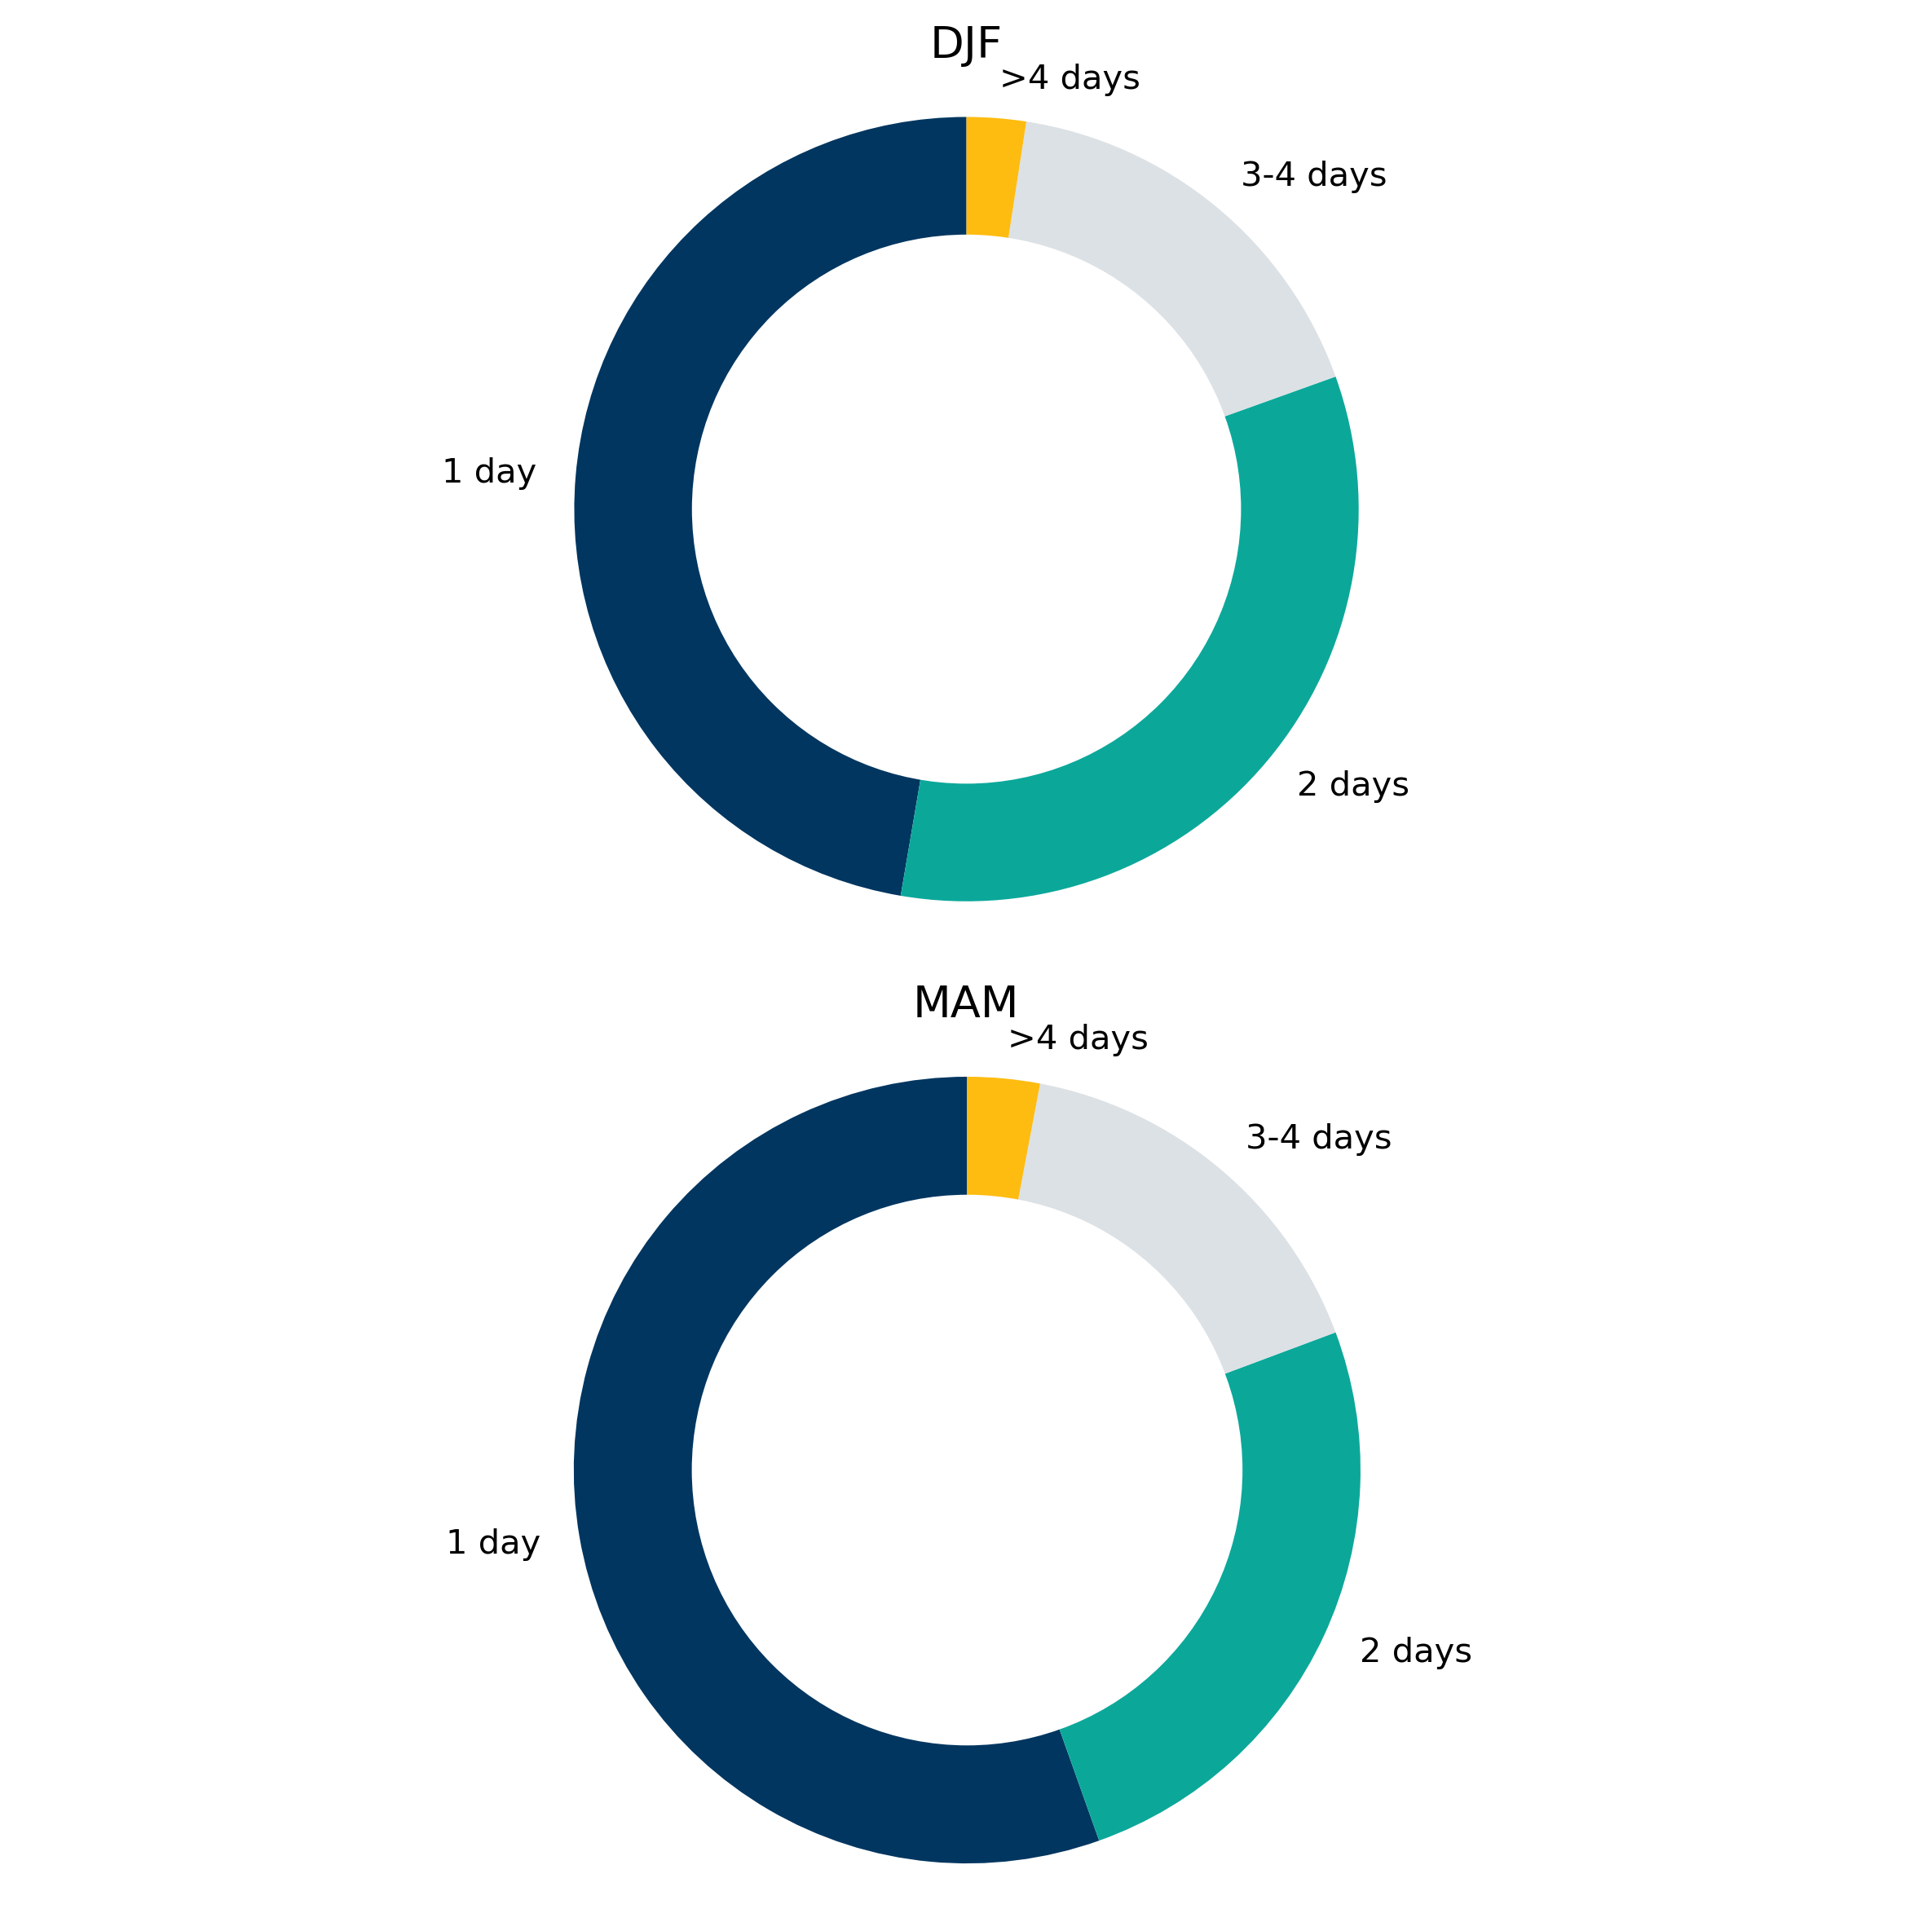

In [17]:
fname = path_to_figs + 'donut_plot_duration_freq'
fmt = 'png'

# Pie chart
plt_labels = ['DJF', 'MAM']
labels = ['1 day', '2 days', '3-4 days', '>4 days']
#colors
colors = ['#003660','#0BA89A','#DCE1E5', '#FEBC11']
 
fig = plt.figure()
fig.set_size_inches((8.,8.))
fig.dpi = 300
nrows = 2
ncols = 1
nplots = nrows*ncols
for i in np.arange(nplots):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.pie(sizes[i], colors = colors, labels=labels, autopct=None, startangle=90)
    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')  
    plt.title(plt_labels[i], fontsize=13)

plt.tight_layout()
# plt.show()

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=300)

plotFile = fname + '.png'
print(plotFile)